# Text classification with RNN

In this notebook we will cover a couple of tips and tricks for tweaking a neural text classifier. We will use an LSTM model for our experiments. We use torch version 1.4.
The code is inspired by [this](https://github.com/lukysummer/Movie-Review-Sentiment-Analysis-LSTM-Pytorch/blob/master/sentiment_analysis_LSTM.py) repository.

### 1. LOAD THE TRAINING TEXT

In [ ]:
from sklearn.datasets import load_files

In [ ]:
from nltk import download

In [ ]:
download("movie_reviews", download_dir="data")

[nltk_data] Downloading package movie_reviews to data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

In [ ]:
movies = load_files("./data/corpora/movie_reviews")

In [ ]:
reviews, encoded_labels = [review.decode() for review in movies.data], movies.target

In [ ]:
import pandas as pd

df_reviews = pd.DataFrame({'reviews': reviews, 'encoded_labels': encoded_labels})
df_reviews

,reviews,encoded_labels
0,arnold schwarzenegger has been an icon for act...,0
1,good films are hard to find these days . \ngre...,1
2,quaid stars as a man who has taken up the prof...,1
3,we could paraphrase michelle pfieffer's charac...,0
4,kolya is one of the richest films i've seen in...,1
...,...,...
1995,"under any other circumstances , i would not be...",0
1996,bruce barth's mellow piano plays in the backgr...,1
1997,""" a man is not a man without eight taels of g...",1
1998,this is a film that i was inclined to like at ...,0


### 2. TEXT PRE-PROCESSING

In [ ]:
from string import punctuation
import re

word_re = re.compile(r"\b[a-z]{2,}\b")

def tokenize(text):
    processed_text = "".join(ch for ch in text.lower() if ch not in punctuation)
    processed_text = processed_text.replace("\n", " ")
    return word_re.findall(processed_text)

def flatten(tokenized_texts):
    return [word for text in tokenized_texts for word in text]

In [ ]:
all_reviews = df_reviews['reviews'].apply(tokenize)
all_words = pd.Series(flatten(all_reviews))
all_words

,0
0,arnold
1,schwarzenegger
2,has
3,been
4,an
...,...
1239602,go
1239603,about
1239604,getting
1239605,the


### 3. CREATE DICTIONARIES & ENCODE REVIEWS

In [ ]:
%pip install -q gensim

In [ ]:
import gensim.downloader as api
import pandas as pd

pd.DataFrame(api.info()['models']).head().T;

In [ ]:
wv = api.load('glove-wiki-gigaword-50')  # в 2 раза быстрее грузится
# wv = api.load(f'glove-twitter-100')

In [ ]:
list(api.info()['models'])

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [ ]:
# word_counts = all_words.value_counts()
# word_ids = range(1, word_counts.size+1)
# int_to_vocab = pd.Series(word_counts.index, index=word_ids)
# vocab_to_int = pd.Series(word_ids, index=word_counts.index)
# encoded_reviews = all_reviews.apply(lambda x: vocab_to_int[x].values)
# encoded_reviews

In [ ]:
vocab = pd.Series(wv.key_to_index) + 1
encoded_reviews = all_reviews.apply(lambda x: [vocab.get(w, 0) for w in x])
encoded_reviews

,reviews
0,"[5819, 6681, 32, 52, 30, 7884, 11, 609, 14345,..."
1,"[220, 1589, 33, 606, 5, 597, 159, 250, 354, 15..."
2,"[32011, 1570, 20, 301, 39, 32, 493, 61, 1, 0, ..."
3,"[54, 95, 43505, 7085, 0, 1396, 7, 2293, 5837, ..."
4,"[113936, 15, 49, 4, 1, 8570, 1589, 79290, 542,..."
...,...
1995,"[125, 131, 69, 3499, 55, 37, 31, 5641, 1, 1946..."
1996,"[3966, 398596, 28899, 4810, 1382, 7, 1, 2094, ..."
1997,"[301, 15, 37, 301, 297, 503, 172508, 4, 765, 3..."
1998,"[38, 15, 320, 13, 16, 11730, 5, 118, 23, 1, 14..."


In [ ]:
lenght = encoded_reviews.apply(len)
lenght

,reviews
0,526
1,521
2,304
3,328
4,114
...,...
1995,707
1996,476
1997,893
1998,457


In [ ]:
lenght.describe()

,reviews
count,2000.000000
mean,619.803500
std,274.825196
min,16.000000
25%,434.000000
50%,580.000000
75%,747.250000
max,2263.000000


<Axes: >

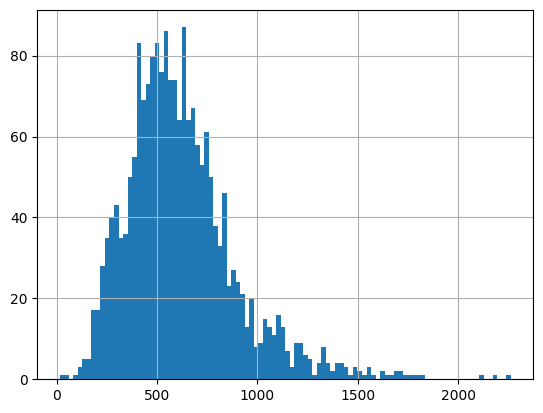

In [ ]:
lenght.hist(bins=100)

In [ ]:
# from collections import Counter

# word_counts = Counter(all_words)
# word_list = sorted(word_counts, key=lambda k: word_counts[k], reverse = True)
# vocab_to_int = {word:idx+1 for idx, word in enumerate(word_list)}
# int_to_vocab = {idx:word for word, idx in vocab_to_int.items()}
# encoded_reviews = all_reviews.apply(lambda x: vocab_to_int[x].values)
# # encoded_reviews = [[vocab_to_int[word] for word in review] for review in all_reviews]

### 6. MAKE ALL REVIEWS SAME LENGTH

In [ ]:
import numpy as np
import torch

# encoded_labels = np.array( [label for idx, label in enumerate(encoded_labels) if len(encoded_reviews[idx]) > 0] )
# encoded_reviews = [review for review in encoded_reviews if len(review) > 0]

In [ ]:
def pad_review(encoded_reviews, seq_length=200):
    review = encoded_reviews[:seq_length]
    padded_review = np.zeros(seq_length, dtype=int)
    padded_review[-len(review):] = review
    return padded_review

padded_reviews = np.stack(encoded_reviews.apply(pad_review, seq_length=750))
padded_reviews

array([[    0,     0,     0, ...,    30, 10015,  1222],
       [    0,     0,     0, ...,  4295,    23,   365],
       [    0,     0,     0, ...,     7,     1,  5231],
       ...,
       [  301,    15,    37, ..., 26191,  1473,     4],
       [    0,     0,     0, ...,    21, 46769,  1567],
       [    0,     0,     0, ...,   882,     1, 12986]])

In [ ]:
# def pad_text(encoded_reviews, seq_length):

#     reviews = []

#     for review in encoded_reviews:
#         if len(review) >= seq_length:
#             reviews.append(review[:seq_length])
#         else:
#             reviews.append([0] * (seq_length - len(review)) + review)

#     return np.array(reviews)

# padded_reviews = pad_text(encoded_reviews, seq_length=200)

In [ ]:
def pad_batch(batch, seq_length=200):
    max_len = max(map(len, batch))
    seq_length = min(seq_length, max_len)
    padded_batch = [pad_review(review, seq_length=seq_length) for review in batch]
    return padded_batch


```
[0 0 1 1 1 1 2 2 2]
[0 1 1 1 1 1 2 2 2]
[1 1 1 1 1 1 2 2 2]
[0 0 1]
[0 1 2]
[2 3 4]
[0 0 1 1 1 1]
[0 1 1 1 1 1]
[1 1 1 1 1 1]
```



### 7. SPLIT DATA & GET (REVIEW, LABEL) DATALOADER

In [ ]:
train_ratio = 0.8
valid_ratio = (1 - train_ratio)/2
total = padded_reviews.shape[0]
train_cutoff = int(total * train_ratio)
valid_cutoff = int(total * (1 - valid_ratio))

train_x, train_y = torch.from_numpy(padded_reviews[:train_cutoff]), torch.from_numpy(encoded_labels[:train_cutoff])
valid_x, valid_y = torch.from_numpy(padded_reviews[train_cutoff:valid_cutoff]), torch.from_numpy(encoded_labels[train_cutoff:valid_cutoff])
test_x, test_y = torch.from_numpy(padded_reviews[valid_cutoff:]), torch.from_numpy(encoded_labels[valid_cutoff:])

from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(train_x, train_y)
valid_data = TensorDataset(valid_x, valid_y)
test_data = TensorDataset(test_x, test_y)

BATCH_SIZE = 256
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True)

### 8. DEFINE THE LSTM MODEL

During the model definition step, we might re-implement model weight initialisation, apply another tricks such as adding various types of dropout to the needed layers etc. There is a noteworthy [discussion](https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch) on wheather one should initialize weights manually or not, and, if yes, how? The functions that implement various initialisation methods are located in the `torch.nn.init` module.

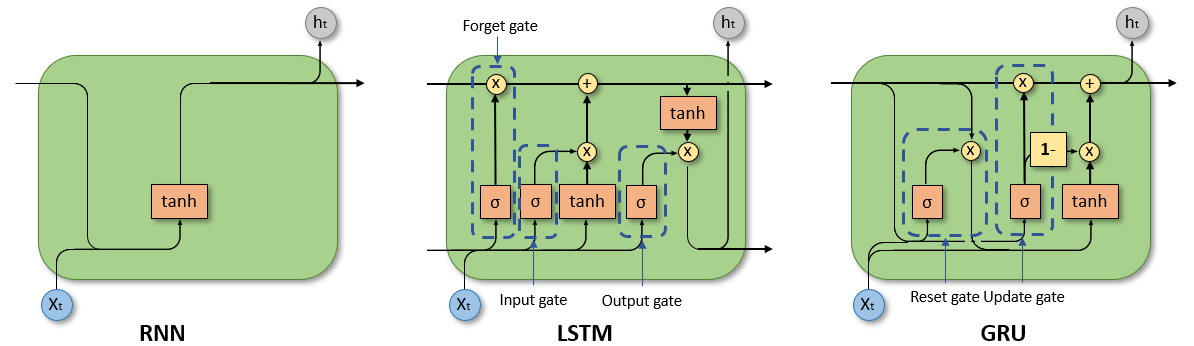

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i_linear = nn.Linear(input_size, hidden_size)
        self.h_linear = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, hidden=None):
        if hidden is None:
            hidden = self.init_hidden()
        for elem in x:
            hidden = torch.tanh(self.i_linear(elem) + self.h_linear(hidden))
        return hidden

    def init_hidden(self):
        return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))

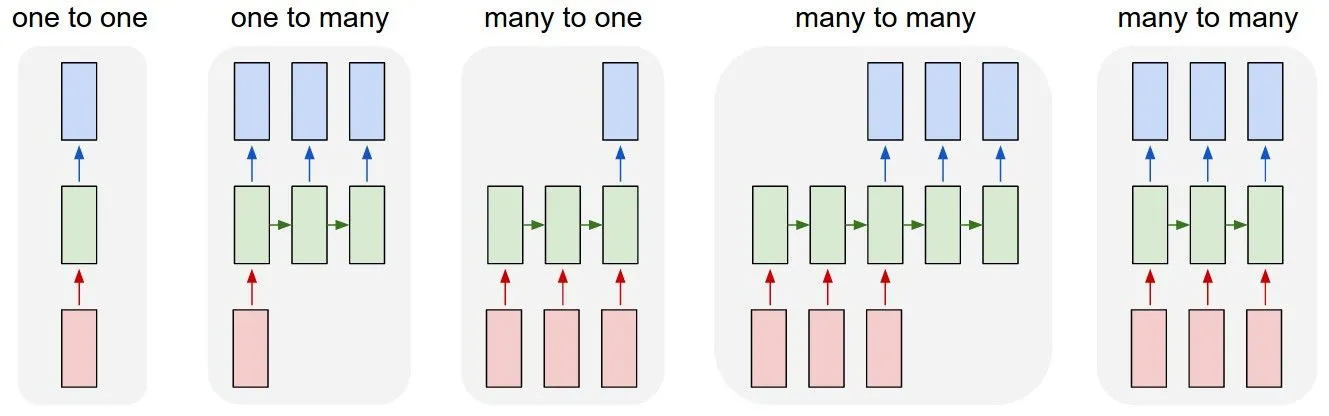

In [ ]:
# torch.cat
wv_torch = torch.from_numpy(wv.vectors)
pad = torch.zeros((1, wv_torch.shape[1]))
wv_torch_with_pad = torch.cat((pad, wv_torch), dim=0)

In [ ]:
# class LinearModel(nn.Module):
#     def __init__(self, embed_size=embed_size, hidden_size=128, n_classes=4):
#         super().__init__()
#         self.emb = nn.Embedding.from_pretrained(wv_torch_with_pad)
#         self.linear = nn.Linear(embed_size, hidden_size)
#         self.rnn = RNN(embed_size, hidden_size)
#         self.clf = nn.Linear(hidden_size, n_classes)
#         self.softmax = nn.Softmax()

#     def forward(self, x):
#         x = self.emb(x)
#         x = self.rnn(x)
#         x = self.clf(x)
#         output = self.softmax(x)
#         return output

In [ ]:
wv_torch_with_pad.shape

torch.Size([400001, 50])

In [ ]:
class SentimentLSTM(nn.Module):

    def __init__(self, n_vocab, n_embed, n_hidden, n_output, n_layers, drop_p=0.3):
        super().__init__()
        # params: "n_" means dimension

        self.n_vocab = n_vocab     # number of unique words in vocabulary
        self.n_layers = n_layers   # number of LSTM layers
        self.n_hidden = n_hidden   # number of hidden nodes in LSTM

        self.embedding = nn.Embedding.from_pretrained(wv_torch_with_pad, freeze=True)
        # self.embedding = nn.Embedding(n_vocab, n_embed)
        self.hidden = torch.nn.Parameter(torch.zeros([2, self.n_layers, 1, self.n_hidden]))
        self.lstm = nn.LSTM(n_embed, n_hidden, n_layers, batch_first=True, dropout=drop_p)
        self.fc1 = nn.Linear(n_hidden*n_layers, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_output)
        self.dropout = nn.Dropout(drop_p)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward (self, input_words):
        h = self.hidden.expand(-1, -1, len(input_words), -1)
        x = self.embedding(input_words)
        x, (h0, h1) = self.lstm(x, (h[0].contiguous(), h[1].contiguous()))
        # x = x[:, -1, :]
        x = torch.cat(list(h0), dim=1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


[source](https://discuss.pytorch.org/t/initialization-of-first-hidden-state-in-lstm-and-truncated-bptt/58384)
```python
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out
```



### 9. INSTANTIATE THE MODEL W/ HYPERPARAMETERS

In [ ]:
# n_vocab = len(vocab_to_int)
# n_embed = 100
n_vocab = wv_torch_with_pad.shape[0]
n_embed = wv_torch_with_pad.shape[1]
n_hidden = 256
n_output = 1   # 1 ("positive") or 0 ("negative")
n_layers = 3

net = SentimentLSTM(n_vocab, n_embed, n_hidden, n_output, n_layers)

In [ ]:
for input_words, labels in (train_loader):
    break
device = 'cuda'
net.to(device)
x = input_words.to(device)
h = net.hidden.expand(-1, -1, len(input_words), -1)
x = net.embedding(input_words.to(device))
x, (h0, h1) = net.lstm(x, (h[0].contiguous(), h[1].contiguous()))
# x = x[:, -1, :]
# x = net.fc(x)
# x = net.sigmoid(x)
x.shape

torch.Size([256, 750, 256])

In [ ]:
out = net(input_words.to(device))
out.shape

torch.Size([256, 1])

### 10. DEFINE LOSS & OPTIMIZER

L2-regularization is already included into SGD optimizer. The `weight_decay` parameter is responsible for controlling its intensity.

In [ ]:
from torch import optim

criterion = nn.BCELoss()
optimizer = optim.AdamW(net.parameters(), lr = 0.001, weight_decay=1e-5)

### 11. TRAIN THE NETWORK!

To prevent the exploding gradient problem in LSTM/RNN we use the `clip_grad_norm_` function, that takes the `clip` parameter.


In [ ]:
temp = next(iter(train_loader))
temp[0].shape

torch.Size([256, 750])

In [ ]:
from tqdm.notebook import tqdm

print_every = 100
step = 0
n_epochs = 100  # validation loss increases from ~ epoch 3 or 4
clip = 5  # gradient clip to prevent exploding gradient problem in LSTM/RNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
net.train()

for epoch in tqdm(range(n_epochs)):
    for inputs, labels in tqdm(train_loader):
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
        output = net(inputs)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        optimizer.zero_grad()

    if (epoch % 10) == 0:
        ######################
        ##### VALIDATION #####
        ######################
        net.eval()
        valid_losses = []
        num_correct = 0

        for v_inputs, v_labels in valid_loader:
            v_inputs, v_labels = inputs.to(device), labels.to(device)
            v_output = net(v_inputs)
            v_loss = criterion(v_output.squeeze(), v_labels.float())
            valid_losses.append(v_loss.item())

            preds = torch.round(v_output.squeeze())
            correct_tensor = preds.eq(v_labels.float().view_as(preds))
            correct = np.squeeze(correct_tensor.cpu().numpy())
            num_correct += np.sum(correct)

        accuracy = (output.squeeze().round() == labels.float()).float().mean()
        # v_accuracy = (v_output.squeeze().round() == v_labels.float()).float().mean()
        print("Epoch: {}/{}".format((epoch+1), n_epochs),
              "Step: {}".format(step),
              "Train_Acc: {:.4f}".format(accuracy.item()),
              "Val_Acc: {:.4f}".format(num_correct / len(valid_loader.dataset)),
              "Train_Loss: {:.4f}".format(loss.item()),
              "Val_Loss: {:.4f}".format(np.mean(valid_losses)))
        net.train()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1/100 Step: 7 Train_Acc: 0.5000 Val_Acc: 0.2100 Train_Loss: 0.6919 Val_Loss: 0.6846


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 11/100 Step: 77 Train_Acc: 0.6875 Val_Acc: 0.2500 Train_Loss: 0.5450 Val_Loss: 0.5275


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 21/100 Step: 147 Train_Acc: 0.6250 Val_Acc: 0.2100 Train_Loss: 0.6325 Val_Loss: 0.6150


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 31/100 Step: 217 Train_Acc: 0.8281 Val_Acc: 0.2600 Train_Loss: 0.4167 Val_Loss: 0.4085


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 41/100 Step: 287 Train_Acc: 0.7500 Val_Acc: 0.2600 Train_Loss: 0.4672 Val_Loss: 0.4336


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 51/100 Step: 357 Train_Acc: 0.8594 Val_Acc: 0.3100 Train_Loss: 0.2335 Val_Loss: 0.1351


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 61/100 Step: 427 Train_Acc: 0.9844 Val_Acc: 0.3200 Train_Loss: 0.0708 Val_Loss: 0.0154


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 71/100 Step: 497 Train_Acc: 0.9688 Val_Acc: 0.3150 Train_Loss: 0.0504 Val_Loss: 0.0308


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 81/100 Step: 567 Train_Acc: 1.0000 Val_Acc: 0.3200 Train_Loss: 0.0045 Val_Loss: 0.0013


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 91/100 Step: 637 Train_Acc: 1.0000 Val_Acc: 0.3200 Train_Loss: 0.0035 Val_Loss: 0.0014


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

### 12. TEST THE TRAINED MODEL ON THE TEST SET

In [ ]:
net.eval()
test_losses = []
num_correct = 0
# test_h = net.init_hidden(BATCH_SIZE)
net.to(device)
for inputs, labels in test_loader:
    # test_h = tuple([each.data for each in test_h])
    inputs, labels = inputs.to(device), labels.to(device)
    # test_output, test_h = net(inputs, test_h)
    test_output = net(inputs)
    loss = criterion(test_output, labels.float().unsqueeze(dim=1))
    test_losses.append(loss.item())

    preds = torch.round(test_output.squeeze())
    correct_tensor = preds.eq(labels.float().view_as(preds))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct / len(test_loader.dataset)))

Test Loss: 3.4505
Test Accuracy: 0.66


In [ ]:
# inputs, labels = next(iter(test_loader))

### 13. TEST THE TRAINED MODEL ON A RANDOM SINGLE REVIEW

In [ ]:
def predict(net, review, seq_length=200):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    words = tokenize(review)
    encoded_words = [vocab_to_int[word] for word in words]
    padded_words = pad_review(encoded_words, seq_length)
    padded_words = torch.from_numpy(padded_words.reshape(1, -1)).to(device)

    if(len(padded_words) == 0):
        "Your review must contain at least 1 word!"
        return None

    net.eval()
    h = net.init_hidden(1)
    # output, h = net(padded_words, h)
    output = net(padded_words)
    pred = torch.round(output.squeeze())
    msg = "This is a positive review." if pred == 0 else "This is a negative review."

    print(msg)


review1 = "It made me cry."
review2 = "It was so good it made me cry."
review3 = "It's ok."
review4 = "This movie had the best acting and the dialogue was so good. I loved it."
review5 = "Garbage"
                       ### OUTPUT ###
predict(net, review1)  ## negative ##
predict(net, review2)  ## positive ##
predict(net, review3)  ## negative ##
predict(net, review4)  ## positive ##
predict(net, review5)  ## negative ##

NameError: name 'vocab_to_int' is not defined

# Tagging

[source](https://github.com/baaraban/pytorch_ner)

Prepare data:

In [ ]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


training_data = [
    ("EU rejects German call to boycott British lamb .".split(), ["B-ORG", "O", "B-MISC", "O", "O", "O", "B-MISC", "O", "O"]),
    ("Only France and Britain backed Fisher 's proposal .".split(), ["O", "B-LOC", "O", "B-LOC", "O", "B-PER", "O", "O", "O"]),
    ("Germany imported 47,600 sheep from Britain last year , nearly half of total imports .".split(),
                                          ["B-LOC", "O", "O", "O", "O", "B-LOC", "O", "O", "O", "O", "O", "O", "O", "O", "O"]),
    ("Rare Hendrix song draft sells for almost $ 17,000 .".split(), ["O", "B-PER", "O", "O", "O", "O", "O", "O", "O", "O"]),
    ("The guitarist died of a drugs overdose in 1970 aged 27 .".split(), ["O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O"]),
    ("China says Taiwan spoils almosphere for talks .".split(), ["B-LOC", "O", "B-LOC", "O", "O", "O", "O", "O"])
]
word_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(word_to_ix)
tag_to_ix = {"O": 0, "B-ORG": 1, "B-LOC": 2, "B-PER": 3, "B-MISC": 4}

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

{'EU': 0, 'rejects': 1, 'German': 2, 'call': 3, 'to': 4, 'boycott': 5, 'British': 6, 'lamb': 7, '.': 8, 'Only': 9, 'France': 10, 'and': 11, 'Britain': 12, 'backed': 13, 'Fisher': 14, "'s": 15, 'proposal': 16, 'Germany': 17, 'imported': 18, '47,600': 19, 'sheep': 20, 'from': 21, 'last': 22, 'year': 23, ',': 24, 'nearly': 25, 'half': 26, 'of': 27, 'total': 28, 'imports': 29, 'Rare': 30, 'Hendrix': 31, 'song': 32, 'draft': 33, 'sells': 34, 'for': 35, 'almost': 36, '$': 37, '17,000': 38, 'The': 39, 'guitarist': 40, 'died': 41, 'a': 42, 'drugs': 43, 'overdose': 44, 'in': 45, '1970': 46, 'aged': 47, '27': 48, 'China': 49, 'says': 50, 'Taiwan': 51, 'spoils': 52, 'almosphere': 53, 'talks': 54}


Create the model:

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.softmax(tag_space, dim=1)
        return tag_scores

Train the model:

In [ ]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    print(tag_scores)

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)

    # The sentence is "EU rejects German call to boycott British lamb .".
    # i,j corresponds to score for tag j for word i. The predicted tag is
    # the maximum scoring tag.
    # Here, we can see the predicted sequence below is 1 0 2 0 0 0 2 0 0
    # since 1 is index of the maximum value of row 1,
    # 0 is the index of maximum value of row 2, etc.
    # Which is B-ORG O B-MISC O..., the correct sequence!
    print(tag_scores)

tensor([[0.1715, 0.1771, 0.2320, 0.2088, 0.2107],
        [0.1759, 0.1756, 0.2291, 0.2132, 0.2061],
        [0.1750, 0.1794, 0.2217, 0.2249, 0.1991],
        [0.1756, 0.1855, 0.2121, 0.2375, 0.1893],
        [0.1516, 0.1970, 0.2277, 0.2133, 0.2104],
        [0.1482, 0.2042, 0.2152, 0.2415, 0.1908],
        [0.1416, 0.1926, 0.2330, 0.2226, 0.2103],
        [0.1430, 0.2197, 0.2034, 0.2515, 0.1825],
        [0.1417, 0.2187, 0.2137, 0.2226, 0.2034]])
tensor([[9.9297e-01, 1.7182e-03, 1.8781e-03, 1.8396e-03, 1.5972e-03],
        [9.9701e-01, 7.3402e-04, 7.6926e-04, 8.2820e-04, 6.5431e-04],
        [9.9757e-01, 5.5063e-04, 6.6690e-04, 6.5695e-04, 5.5671e-04],
        [9.9817e-01, 4.0946e-04, 4.9980e-04, 5.0778e-04, 4.1211e-04],
        [9.9850e-01, 3.3239e-04, 4.1419e-04, 3.9428e-04, 3.5619e-04],
        [9.9775e-01, 4.9500e-04, 6.2185e-04, 6.2067e-04, 5.1046e-04],
        [9.9830e-01, 3.9719e-04, 4.5266e-04, 4.6531e-04, 3.8895e-04],
        [9.9832e-01, 3.6822e-04, 4.7175e-04, 4.4085e-04, 4.

In [ ]:
tag_scores.numpy().round(3)

array([[0.993, 0.002, 0.002, 0.002, 0.002],
       [0.997, 0.001, 0.001, 0.001, 0.001],
       [0.998, 0.001, 0.001, 0.001, 0.001],
       [0.998, 0.   , 0.   , 0.001, 0.   ],
       [0.999, 0.   , 0.   , 0.   , 0.   ],
       [0.998, 0.   , 0.001, 0.001, 0.001],
       [0.998, 0.   , 0.   , 0.   , 0.   ],
       [0.998, 0.   , 0.   , 0.   , 0.   ],
       [0.999, 0.   , 0.   , 0.   , 0.   ]], dtype=float32)

## Task

Initialize model embedding layer with pre-trained word2vec embeddings. Train new model with obtained layer. Compare results with  on test dataset.

# 3. Эксперименты

## [3.1] Подготовка данных

### Загрузка данных с `pandas`

In [ ]:
import pandas as pd

sample_path = "/content/sample_data/california_housing_test.csv"
df = pd.read_csv(sample_path)
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085,344700.0
1,-118.30,34.26,43.0,1510.0,310.0,809.0,277.0,3.5990,176500.0
2,-117.81,33.78,27.0,3589.0,507.0,1484.0,495.0,5.7934,270500.0
3,-118.36,33.82,28.0,67.0,15.0,49.0,11.0,6.1359,330000.0
4,-119.67,36.33,19.0,1241.0,244.0,850.0,237.0,2.9375,81700.0
...,...,...,...,...,...,...,...,...,...
2995,-119.86,34.42,23.0,1450.0,642.0,1258.0,607.0,1.1790,225000.0
2996,-118.14,34.06,27.0,5257.0,1082.0,3496.0,1036.0,3.3906,237200.0
2997,-119.70,36.30,10.0,956.0,201.0,693.0,220.0,2.2895,62000.0
2998,-117.12,34.10,40.0,96.0,14.0,46.0,14.0,3.2708,162500.0


In [ ]:
df['longitude'][0]

-122.05

### Загрузка данных с `datasets`
- годная [документация](https://huggingface.co/docs/datasets/loading)

In [ ]:
%pip install -q datasets

In [ ]:
from datasets import load_dataset

dataset_temp = load_dataset("csv", data_files=sample_path)
dataset_temp

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value'],
        num_rows: 3000
    })
})

In [ ]:
dataset_temp['train']['longitude'][0]

-122.05

### Загружаем датасет (AG News)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ag_news")

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [ ]:
dataset['train'][0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

### Токенизация и подготовка

In [ ]:
%pip install -q transformers

In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", max_length=64, truncation=True, return_tensors="pt")

In [ ]:
tokens = dataset.map(tokenize, batched=True)
tokens.set_format(type="torch", columns=["input_ids", "label"])
tokens

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})

In [ ]:
tokens['train'][0]

{'label': tensor(2),
 'input_ids': tensor([  101,  2813,  2358,  1012,  6468, 15020,  2067,  2046,  1996,  2304,
          1006, 26665,  1007, 26665,  1011,  2460,  1011, 19041,  1010,  2813,
          2395,  1005,  1055,  1040, 11101,  2989,  1032,  2316,  1997, 11087,
          1011, 22330,  8713,  2015,  1010,  2024,  3773,  2665,  2153,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0])}

### train_test_split

In [ ]:
from torch.utils.data import DataLoader

batch_size = 1024
train_loader = DataLoader(tokens["train"], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tokens["test"], batch_size=batch_size)

## [3.2] Torch Embeddings

In [ ]:
%pip install -q gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.7 MB/s eta 0:00:00


In [ ]:
import gensim.downloader as api

embeddings = api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


### Embeddings

In [ ]:
import torch

# Создаём словарь word -> index
word2idx = {word: i for i, word in enumerate(embeddings.index_to_key)}

# Превращаем numpy-массив в тензор
embedding_matrix = torch.tensor(embeddings.vectors, dtype=torch.float32)

# Создаём слой эмбеддингов
glove_embedding = torch.nn.Embedding.from_pretrained(embedding_matrix, freeze=True)

In [ ]:
# Пример: Получаем эмбеддинг для слова "hello"
word = "hello"
if word in word2idx:
    idx = torch.tensor([word2idx[word]])
    vector = glove_embedding(idx)
    print(vector.shape)  # (1, 50)

torch.Size([1, 50])


In [ ]:
vector

tensor([[-0.3850,  0.8009,  0.0641, -0.2835, -0.0268, -0.3453, -0.6425, -0.1173,
         -0.3326,  0.5524, -0.0878,  0.9035,  0.4710,  0.5666,  0.6985, -0.3523,
         -0.8654,  0.9057,  0.0358, -0.0717, -0.1233,  0.5492,  0.4701,  0.3557,
          1.2611, -0.6758, -0.9498,  0.6867,  0.3871, -1.3492,  0.6351,  0.4642,
         -0.4881,  0.8383, -0.9246, -0.3372,  0.5374, -1.0616, -0.0814, -0.6711,
          0.3092, -0.3923, -0.5500, -0.6883,  0.5805, -0.1163,  0.0131, -0.5765,
          0.0488,  0.6720]])

In [ ]:
embeddings[word]

array([-0.38497 ,  0.80092 ,  0.064106, -0.28355 , -0.026759, -0.34532 ,
       -0.64253 , -0.11729 , -0.33257 ,  0.55243 , -0.087813,  0.9035  ,
        0.47102 ,  0.56657 ,  0.6985  , -0.35229 , -0.86542 ,  0.90573 ,
        0.03576 , -0.071705, -0.12327 ,  0.54923 ,  0.47005 ,  0.35572 ,
        1.2611  , -0.67581 , -0.94983 ,  0.68666 ,  0.3871  , -1.3492  ,
        0.63512 ,  0.46416 , -0.48814 ,  0.83827 , -0.9246  , -0.33722 ,
        0.53741 , -1.0616  , -0.081403, -0.67111 ,  0.30923 , -0.3923  ,
       -0.55002 , -0.68827 ,  0.58049 , -0.11626 ,  0.013139, -0.57654 ,
        0.048833,  0.67204 ], dtype=float32)

### Tolenizer

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download(["punkt", "punkt_tab"])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Функция токенизации
def tokenize(text):
    tokens = word_tokenize(text.lower())  # Токенизация и приведение к lowercase
    token_ids = [word2idx[word] for word in tokens if word in word2idx]  # Пропускаем OOV-слова
    return torch.tensor(token_ids, dtype=torch.long)  # Конвертируем в тензор

text = "Hello world! This is an NLP example."
tokenize(text)

tensor([13075,    85,   805,    37,    14,    29, 57407,   880,     2])

In [ ]:
def batch_tokenize(batch):
    tokenized_texts = [tokenize(text) for text in batch["text"]]
    return {"input_ids": tokenized_texts}  # Возвращаем список списков

# Токенизируем датасет
tokens = dataset.map(batch_tokenize, batched=True)

# Устанавливаем формат для PyTorch
tokens.set_format(type="torch", columns=["input_ids", "label"])


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
dataset.map(tokenize)

tokens = dataset.map(tokenize)
tokens
# tokens.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
# tokens

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

AttributeError: 'LazyRow' object has no attribute 'lower'

tensor([13075,    85,   805,    37,    14,    29, 57407,   880,     2])

In [ ]:
x = tokenize(text).unsqueeze(0)

x = glove_embedding(x).mean(dim=1)
x.shape

torch.Size([1, 50])

## [3.3] Архитектуры

In [ ]:
import torch
import torch.nn as nn

In [ ]:
# NN

class TextClassifier(nn.Module):
    def __init__(self, embedding_matrix, embed_dim=50, hidden_dim=128, num_classes=4):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.emb(x).mean(dim=1)  # Усредняем эмбеддинги слов в предложении
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# CNN

class TextCNN(nn.Module):
    def __init__(self, embedding_matrix, embed_dim=50, num_classes=4, num_filters=100, kernel_sizes=(3, 4)):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)

        # Два свёрточных слоя с разными размерам окон
        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=kernel_sizes[0])
        self.conv2 = nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=kernel_sizes[1])

        self.fc = nn.Linear(num_filters * 2, num_classes)  # Полносвязный выходной слой

    def forward(self, x):
        x = self.emb(x).permute(0, 2, 1)  # Переставляем оси для Conv1d (batch, channels, seq_length)

        x1 = torch.relu(self.conv1(x))
        x2 = torch.relu(self.conv2(x))

        x1 = torch.max(x1, dim=2)[0]  # Max-pooling по временной оси
        x2 = torch.max(x2, dim=2)[0]

        x = torch.cat([x1, x2], dim=1)  # Объединяем фичи от двух свёрток
        return self.fc(x)  # Выходной слой


In [ ]:
# RNN

class TextGRU(nn.Module):
    def __init__(self, embedding_matrix, embed_dim=50, hidden_dim=128, num_classes=4, num_layers=2):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 из-за bidirectional GRU

    def forward(self, x):
        x = self.emb(x)  # Векторизация слов
        x, _ = self.gru(x)  # Прогон через GRU
        x = x[:, -1, :]  # Берём последнее скрытое состояние (можно взять max-pooling)
        return self.fc(x)  # Классификация

In [ ]:
# RCNN

class TextRCNN(nn.Module):
    def __init__(self, embedding_matrix, embed_dim=50, hidden_dim=128, num_classes=4, num_layers=1, kernel_size=3):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.conv = nn.Conv1d(in_channels=hidden_dim * 2 + embed_dim, out_channels=hidden_dim, kernel_size=kernel_size, padding=1)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.emb(x)  # (B, T, E)
        lstm_out, _ = self.lstm(x)  # (B, T, H*2)
        x = torch.cat([x, lstm_out], dim=2)  # (B, T, H*2 + E)
        x = x.permute(0, 2, 1)  # (B, H*2+E, T) -> для Conv1d
        x = torch.relu(self.conv(x))  # (B, H, T)
        x = torch.max(x, dim=2)[0]  # Max-pooling по времени (B, H)
        return self.fc(x)  # Классификация (B, num_classes)